In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns

In [2]:
def download_covid_data(url, filename):
    # Enviar una solicitud GET a la URL
    response = requests.get(url)

    # Verificar si la solicitud fue exitosa
    if response.status_code == 200:
        # Escribir el contenido en un archivo
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Archivo descargado con éxito: {filename}")
    else:
        print(f"Fallo en la descarga del archivo. Código : {response.status_code}")


url = 'https://api.covidtracking.com/v1/states/daily.csv'
filename = 'us_daily_state_covid_data.csv'
download_covid_data(url, filename)

Archivo descargado con éxito: us_daily_state_covid_data.csv


In [3]:
df = pd.read_csv('us_daily_state_covid_data.csv')

# Mostrar información básica sobre el DataFrame
print("Información del DataFrame:")
df.info()

print("\nForma del DataFrame:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

print("\nNombres de las columnas:")
print(df.columns.tolist())

print("\nPrimeras filas del DataFrame:")
print(df.head())

print("\nEstadísticas resumidas:")
print(df.describe())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         20780 non-null  int64  
 1   state                        20780 non-null  object 
 2   positive                     20592 non-null  float64
 3   probableCases                9271 non-null   float64
 4   negative                     13290 non-null  float64
 5   pending                      2138 non-null   float64
 6   totalTestResultsSource       20780 non-null  object 
 7   totalTestResults             20614 non-null  float64
 8   hospitalizedCurrently        17339 non-null  float64
 9   hospitalizedCumulative       12382 non-null  float64
 10  inIcuCurrently               11636 non-null  float64
 11  inIcuCumulative              3789 non-null   float64
 12  onVentilatorCurrently        9126 non-null   fl

Estadísticas de NaN:
                             Total NaN  Porcentaje NaN
grade                            20780      100.000000
dataQualityGrade                 20780      100.000000
positiveTestsPeopleAntigen       20147       96.953802
negativeTestsPeopleAntibody      19808       95.322425
totalTestsPeopleAntigen          19781       95.192493
positiveTestsPeopleAntibody      19686       94.735322
onVentilatorCumulative           19490       93.792108
negativeTestsAntibody            19322       92.983638
pending                          18642       89.711261
totalTestsPeopleAntibody         18580       89.412897
positiveTestsAntigen             18547       89.254090
hospitalizedDischarged           17710       85.226179
positiveTestsAntibody            17434       83.897979
totalTestsAntigen                17359       83.537055
inIcuCumulative                  16991       81.766121
totalTestsAntibody               15991       76.953802
negativeTestsViral               15756      

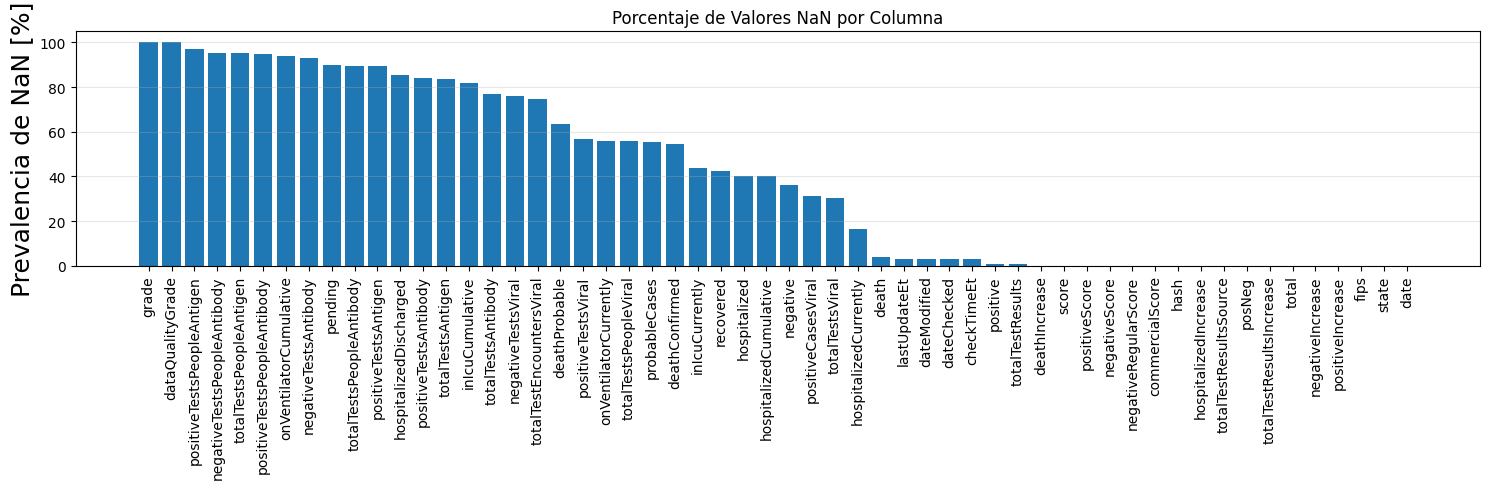

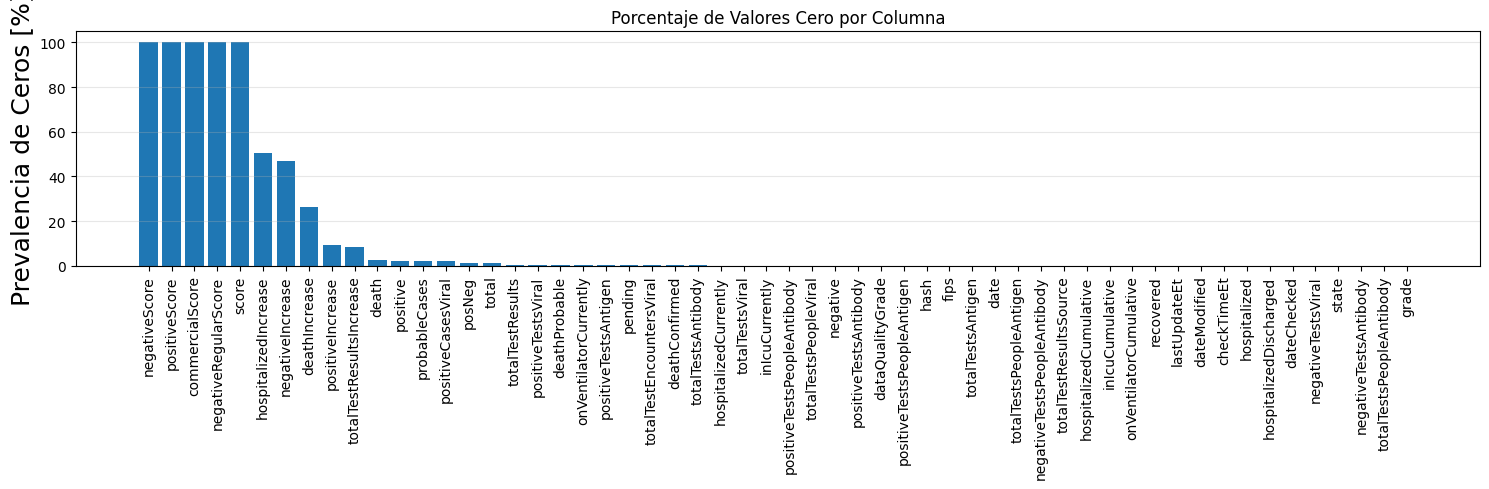

In [4]:
# Calcular el porcentaje de NaN y ceros
total_nans = df.isnull().sum().sort_values(ascending=False)
percent_nans = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
total_zeros = df.isin([0]).sum().sort_values(ascending=False)
percent_zeros = (df.isin([0]).sum() / df.isin([0]).count() * 100).sort_values(ascending=False)

# Crear DataFrames para estadísticas de NaN y ceros
df_nans = pd.concat([total_nans, percent_nans], axis=1, keys=['Total NaN', 'Porcentaje NaN'])
df_zeros = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total Ceros', 'Porcentaje Ceros'])

# Imprimir los resultados
print("Estadísticas de NaN:")
print(df_nans)
print("\nEstadísticas de Ceros:")
print(df_zeros)

# Graficar porcentajes de NaN
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(df_nans)), df_nans['Porcentaje NaN'].values)
plt.xticks(np.arange(len(df_nans)), df_nans.index, rotation='vertical')
plt.ylabel('Prevalencia de NaN [%]', fontsize=18)
plt.title('Porcentaje de Valores NaN por Columna')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
plt.close()

# Graficar porcentajes de Ceros
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(df_zeros)), df_zeros['Porcentaje Ceros'].values)
plt.xticks(np.arange(len(df_zeros)), df_zeros.index, rotation='vertical')
plt.ylabel('Prevalencia de Ceros [%]', fontsize=18)
plt.title('Porcentaje de Valores Cero por Columna')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [5]:
# Lista de columnas relevantes
relevant_columns = ['date', 'state', 'fips', 'positiveIncrease', 'negativeIncrease', 'total', 'totalTestResultsIncrease',
                 'posNeg', 'totalTestResultsSource', 'hospitalizedIncrease', 'hash', 'positiveScore', 'negativeScore',
                 'commercialScore', 'negativeRegularScore', 'score', 'deathIncrease', 'totalTestResults', 'positive',
                 'checkTimeEt', 'dateChecked', 'dateModified', 'lastUpdateEt', 'death', 'hospitalizedCurrently']


# Nos quedamos con esas columnas para el análisis
df = df[relevant_columns]


In [6]:
# Convertir la fecha a datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Ordenar por fecha
df = df.sort_values('date')
df.reset_index(drop= True, inplace=True)

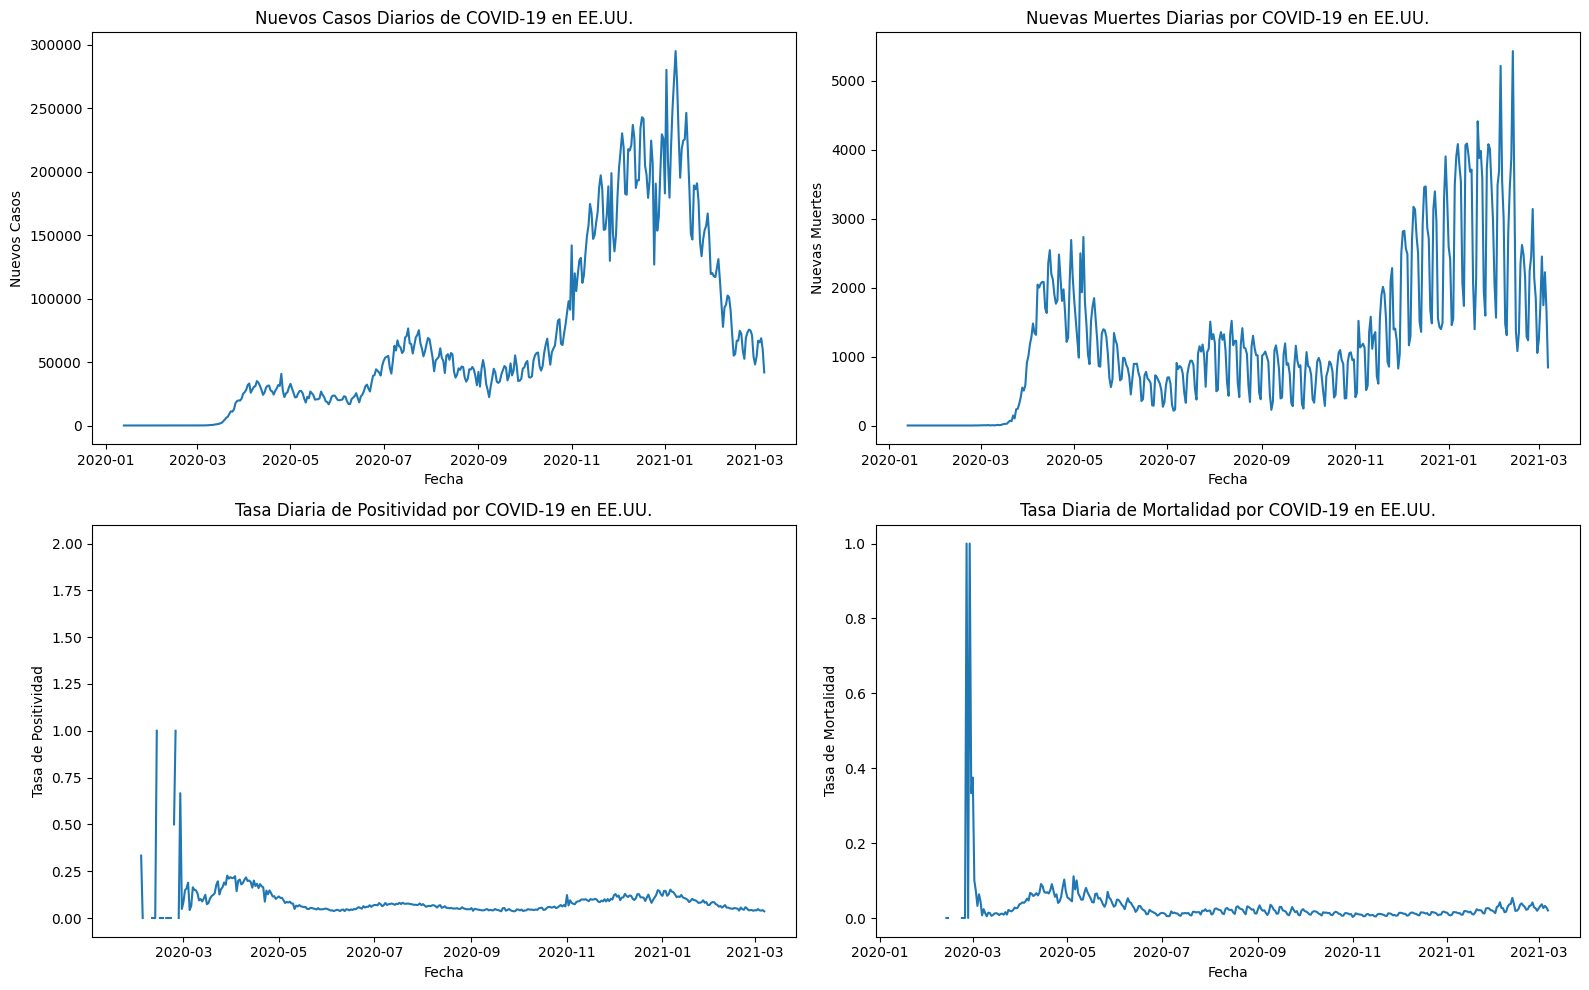

In [7]:
# Agregar los datos a nivel nacional
national_df = df.groupby('date').agg({
    'positiveIncrease': 'sum',
    'deathIncrease': 'sum',
    'totalTestResultsIncrease': 'sum',
    'hospitalizedIncrease': 'sum',
    'positive': 'sum',
    'death': 'sum',
    'total': 'sum',
    'hospitalizedCurrently': 'sum'
}).reset_index()

# Calcular estadísticas diarias
national_df['daily_positivity_rate'] = national_df['positiveIncrease'] / national_df['totalTestResultsIncrease']
national_df['daily_death_rate'] = national_df['deathIncrease'] / national_df['positiveIncrease']

# Graficar tendencias nacionales
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Nuevos casos
axs[0, 0].plot(national_df['date'], national_df['positiveIncrease'])
axs[0, 0].set_title('Nuevos Casos Diarios de COVID-19 en EE.UU.')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Nuevos Casos')

# Nuevas muertes
axs[0, 1].plot(national_df['date'], national_df['deathIncrease'])
axs[0, 1].set_title('Nuevas Muertes Diarias por COVID-19 en EE.UU.')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].set_ylabel('Nuevas Muertes')

# Tasa de positividad
axs[1, 0].plot(national_df['date'], national_df['daily_positivity_rate'])
axs[1, 0].set_title('Tasa Diaria de Positividad por COVID-19 en EE.UU.')
axs[1, 0].set_xlabel('Fecha')
axs[1, 0].set_ylabel('Tasa de Positividad')

# Tasa de mortalidad
axs[1, 1].plot(national_df['date'], national_df['daily_death_rate'])
axs[1, 1].set_title('Tasa Diaria de Mortalidad por COVID-19 en EE.UU.')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].set_ylabel('Tasa de Mortalidad')

plt.tight_layout()
plt.show()

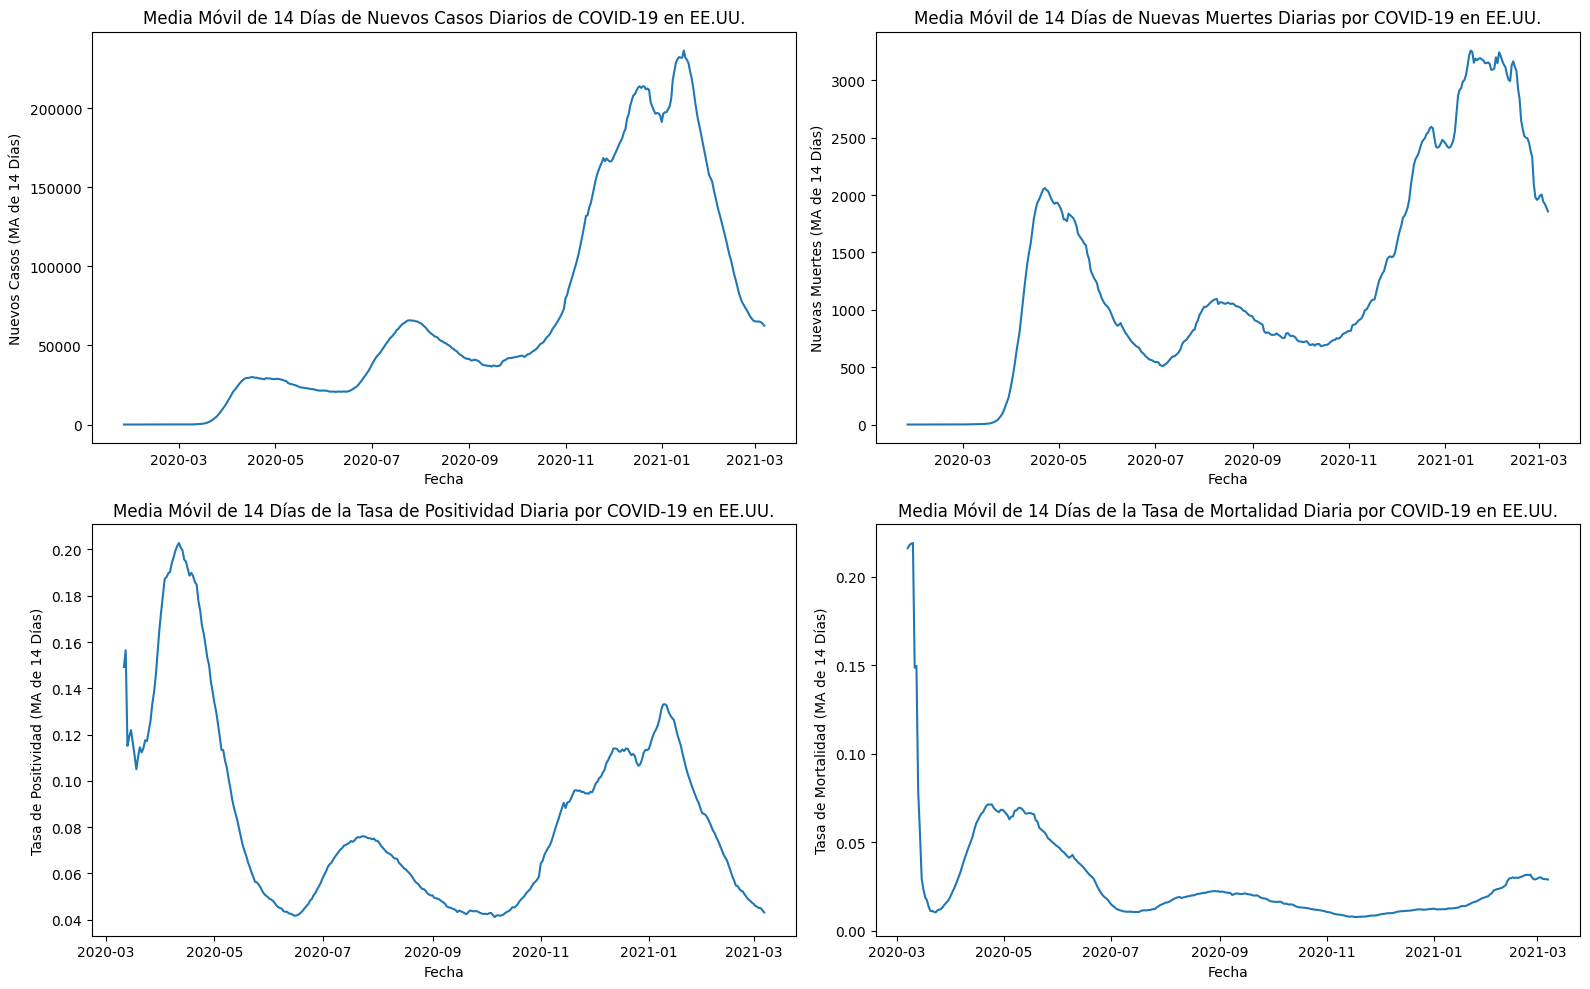

In [21]:
# Calcular medias móviles de 14 períodos
national_df['positiveIncrease_MA'] = national_df['positiveIncrease'].rolling(window=14).mean()
national_df['deathIncrease_MA'] = national_df['deathIncrease'].rolling(window=14).mean()
national_df['daily_positivity_rate_MA'] = national_df['daily_positivity_rate'].rolling(window=14).mean()
national_df['daily_death_rate_MA'] = national_df['daily_death_rate'].rolling(window=14).mean()

# Graficar medias móviles de 14 períodos de las tendencias nacionales
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Nuevos casos (media móvil de 14 días)
axs[0, 0].plot(national_df['date'], national_df['positiveIncrease_MA'])
axs[0, 0].set_title('Media Móvil de 14 Días de Nuevos Casos Diarios de COVID-19 en EE.UU.')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Nuevos Casos (MA de 14 Días)')

# Nuevas muertes (media móvil de 14 días)
axs[0, 1].plot(national_df['date'], national_df['deathIncrease_MA'])
axs[0, 1].set_title('Media Móvil de 14 Días de Nuevas Muertes Diarias por COVID-19 en EE.UU.')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].set_ylabel('Nuevas Muertes (MA de 14 Días)')

# Tasa de positividad (media móvil de 14 días)
axs[1, 0].plot(national_df['date'], national_df['daily_positivity_rate_MA'])
axs[1, 0].set_title('Media Móvil de 14 Días de la Tasa de Positividad Diaria por COVID-19 en EE.UU.')
axs[1, 0].set_xlabel('Fecha')
axs[1, 0].set_ylabel('Tasa de Positividad (MA de 14 Días)')

# Tasa de mortalidad (media móvil de 30 días)
axs[1, 1].plot(national_df['date'], national_df['daily_death_rate_MA'])
axs[1, 1].set_title('Media Móvil de 14 Días de la Tasa de Mortalidad Diaria por COVID-19 en EE.UU.')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].set_ylabel('Tasa de Mortalidad (MA de 14 Días)')

plt.tight_layout()
plt.show()

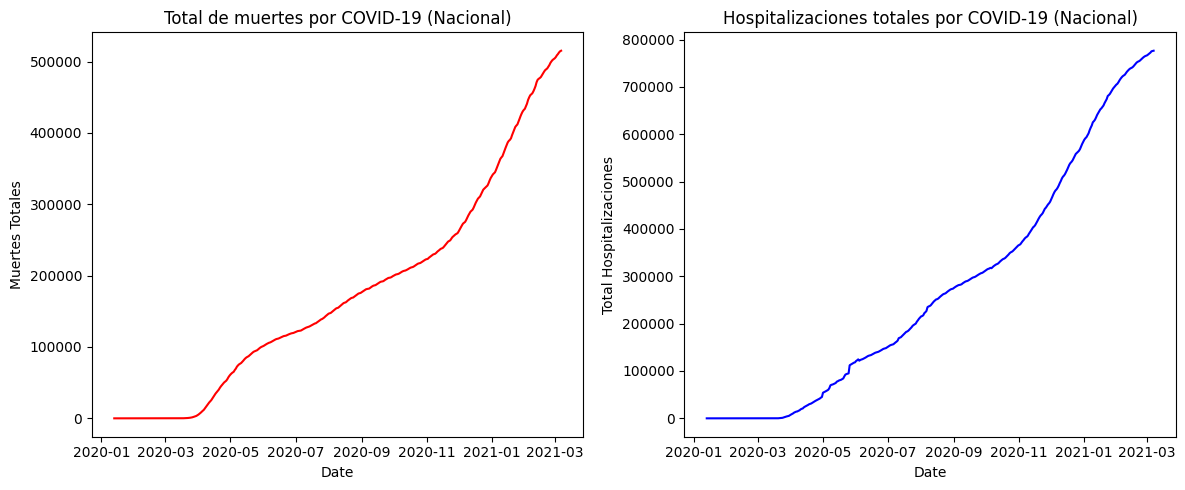

In [9]:

# Totales acumulados
national_df['total_deaths'] = national_df['deathIncrease'].cumsum()
national_df['total_hospitalizations'] = national_df['hospitalizedIncrease'].cumsum()

# Graficamos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Muertes totales
axs[0].plot(national_df['date'], national_df['total_deaths'], color='red')
axs[0].set_title('Total de muertes por COVID-19 (Nacional)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Muertes Totales')

# Total hospitalizations
axs[1].plot(national_df['date'], national_df['total_hospitalizations'], color='blue')
axs[1].set_title('Hospitalizaciones totales por COVID-19 (Nacional)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Total Hospitalizaciones')

plt.tight_layout()
plt.show()


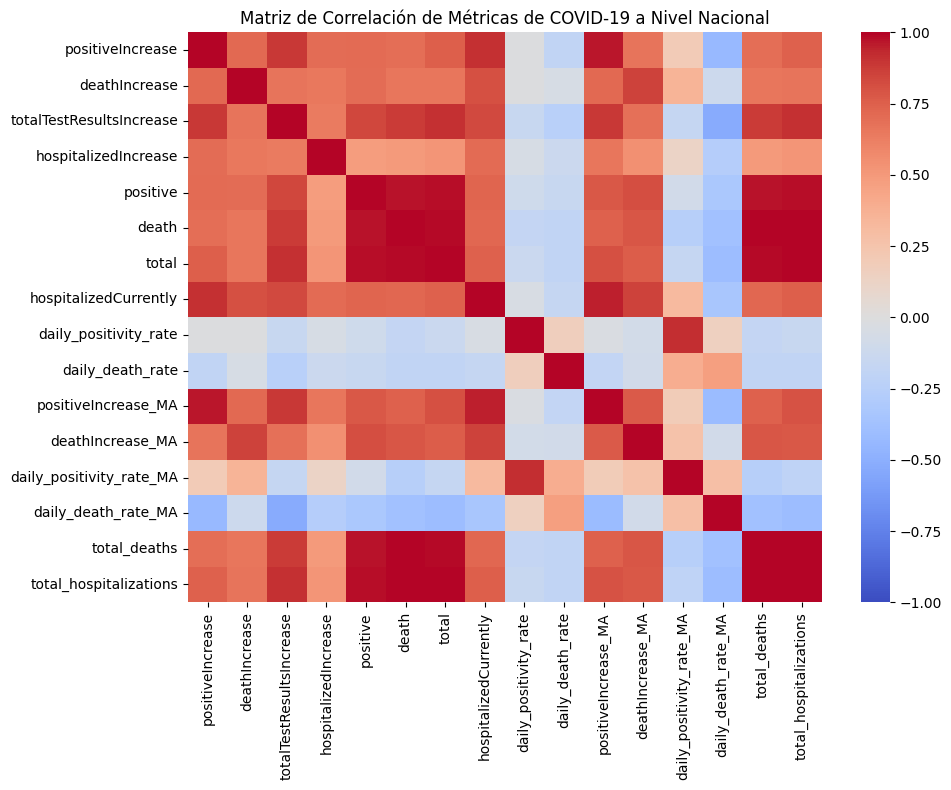

In [10]:
# Eliminar la columna 'date' y crear un DataFrame intermedio
national_df_numeric = national_df.drop(columns=['date'])

# Calcular la matriz de correlación
correlation_matrix = national_df_numeric.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación de Métricas de COVID-19 a Nivel Nacional')
plt.tight_layout()
plt.show()


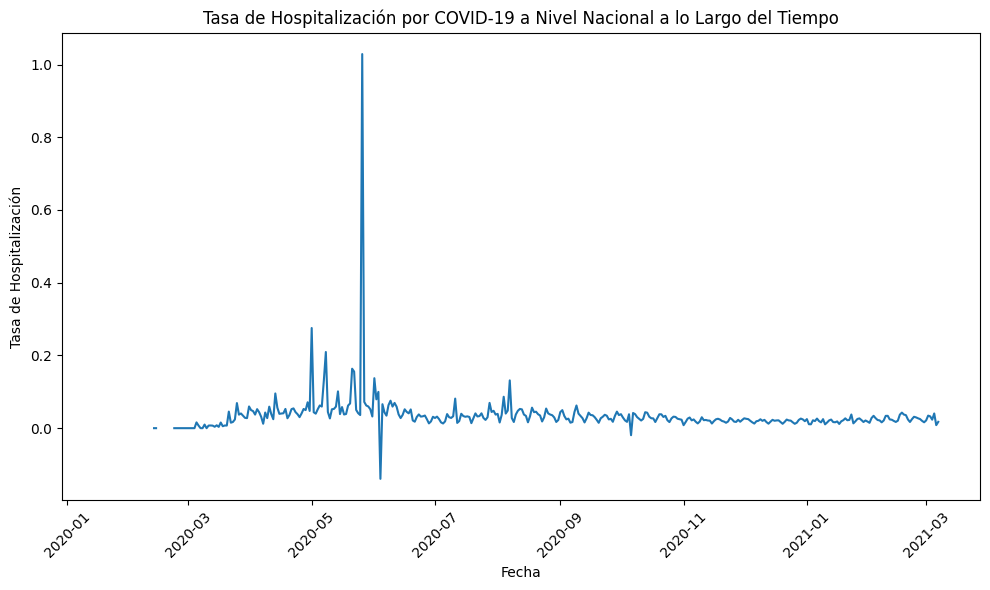

In [11]:
# Tasa de hospitalización a nivel nacional

national_df['hospitalization_rate'] = national_df['hospitalizedIncrease'] / national_df['positiveIncrease']

plt.figure(figsize=(10, 6))
plt.plot(national_df['date'], national_df['hospitalization_rate'])
plt.title('Tasa de Hospitalización por COVID-19 a Nivel Nacional a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Hospitalización')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Análisis y conclusiones a nivel nacional:

## Resumen de Datos
- El análisis se basa en datos diarios a nivel estatal sobre COVID-19 provenientes de la API del COVID Tracking Project.
- El conjunto de datos incluye diversas métricas como nuevos casos, muertes, hospitalizaciones y resultados de pruebas.

## Tendencias Nacionales

### 1. Patrones de Casos y Muertes
- El análisis revela fluctuaciones en los nuevos casos y muertes diarias a lo largo del tiempo.
- Las medias móviles de 14 días muestran tendencias más claras, suavizando las variaciones diarias.
- Las múltiples olas de infecciones vienen indicadas por picos en las medias móviles.

### 2. Pruebas y Tasa de Positividad
- La tasa de positividad diaria (nuevos casos positivos / total de resultados de pruebas) varía con el tiempo.
- Los cambios en la tasa de positividad pueden indicar cambios en las estrategias de prueba o en las tasas de infección.
- Una disminución de la tasa de positividad junto con un aumento de las pruebas generalmente sugiere un mejor control del brote.

### 3. Tendencias de Mortalidad
- La tasa de mortalidad diaria (nuevos fallecimientos / nuevos casos positivos) fluctúa durante el período.
- Los cambios en la tasa de mortalidad  refleja  mejoras en el tratamiento y vacunación, cambios en las poblaciones vulnerables afectadas o retrasos en los informes.

### 4. Patrones de Hospitalización
- La tasa de hospitalización (nuevos ingresos hospitalarios / nuevos casos positivos) varía con el tiempo.


## Análisis de Correlación

El mapa de calor de las correlaciones entre diferentes métricas revela:

- Fuertes correlaciones positivas entre nuevos casos, muertes y total de resultados de pruebas, lo que indica que a medida que aumentaron las pruebas, se identificaron más casos y muertes.


## Conclusiones Clave

1. **Tres Olas**: Los datos sugieren que EE.UU. experimentó tres olas de infecciones por COVID-19 en el periodo analizado , siendo la tercera de mayor intensidad en contagios y muertes totales. Sugiere fallos de planificación y adaptación del sistema sanitario ya que había precedentes. La mortalidad de la primera ola fue lógicamente la mas elevada.

2. **Impacto Variable**: Las fluctuaciones en las tasas de positividad, mortalidad y hospitalización indican que el impacto del COVID-19 varió con el tiempo, debido a factores como medidas de salud pública, adaptaciones del sistema de salud y variantes del virus.

4. **Estrés en el Sistema de Salud**: Las variaciones en las tasas de hospitalización sugieren períodos de mayor estrés en el sistema de salud, lo que puede haber influido en los resultados de los pacientes.

5. **Datos incompletos**: Algunas variaciones y anomalías en los datos podrían deberse a inconsistencias o retrasos en los informes y diferentes políticas de gestión a nivel estatal.
El dataset contiene muchas columnas en desuso que han sido limpiadas


# Análisis a nivel Estatal

In [12]:
# Agrupar los datos por estado y fecha
state_df = df.groupby(['state', 'date']).sum().reset_index()

# Calcular estadísticas resumidas para cada estado
state_summary = state_df.groupby('state').agg({
    'positiveIncrease': 'sum',
    'totalTestResultsIncrease': 'sum',
    'positive': 'max',
    'death': 'max',
    'total': 'sum',
    'positiveIncrease': 'sum',
    'deathIncrease': 'sum',
    'hospitalizedCurrently': 'max',
    'hospitalizedIncrease': 'sum',
}).reset_index()

In [13]:
state_summary['death'].sum()

515254.0

In [ ]:
state_summary

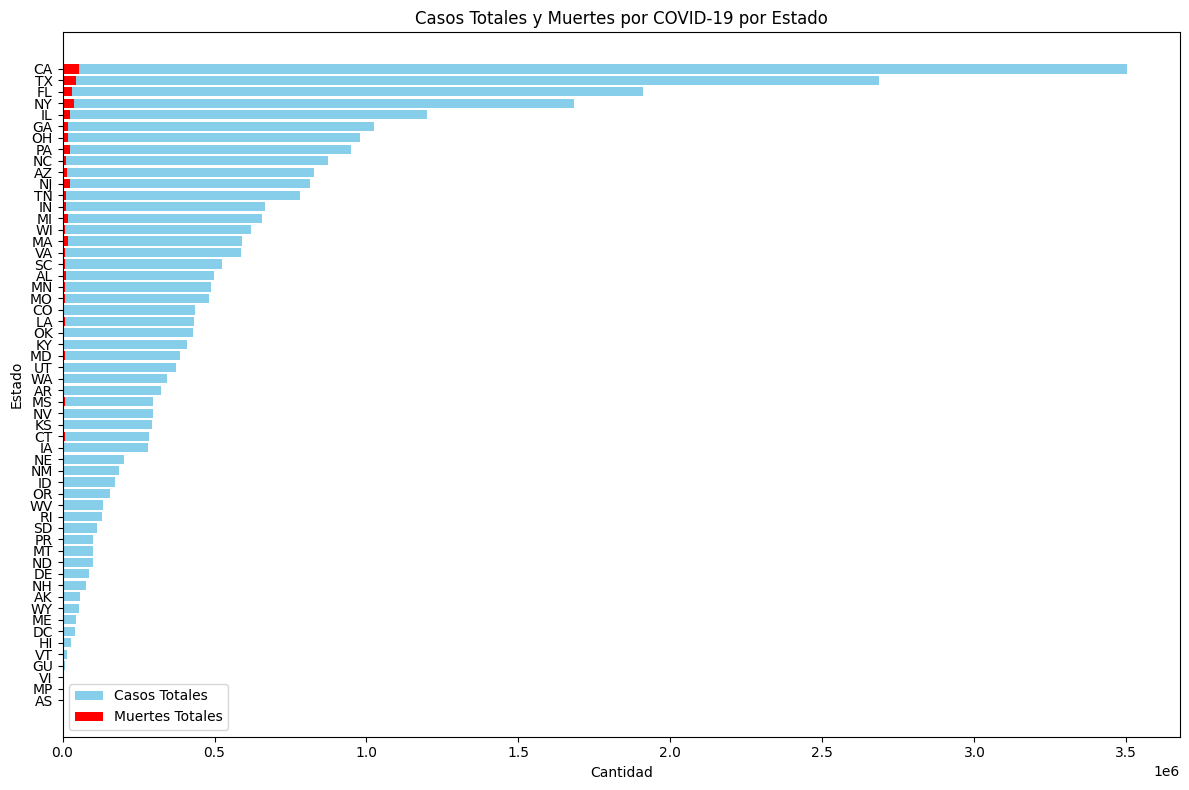

In [15]:
# Ordenar el DataFrame state_summary por la columna 'positive' en orden descendente
state_summary_sorted = state_summary.sort_values(by='positive', ascending=True)

# Graficar casos totales y muertes por estado en orden descendente
plt.figure(figsize=(12, 8))
plt.barh(state_summary_sorted['state'], state_summary_sorted['positive'], color='skyblue', label='Casos Totales')
plt.barh(state_summary_sorted['state'], state_summary_sorted['death'], color='red', label='Muertes Totales')
plt.title('Casos Totales y Muertes por COVID-19 por Estado')
plt.xlabel('Cantidad')
plt.ylabel('Estado')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


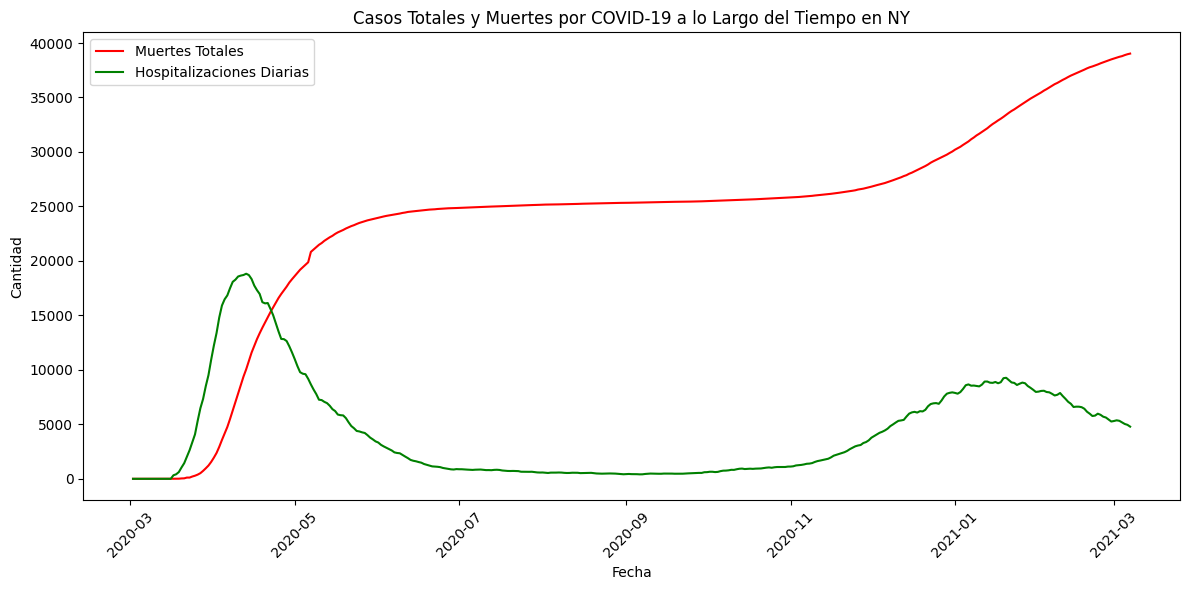

In [16]:
# Función para graficar datos de series temporales para un estado específico
def plot_state_data(state_code):
    state_data = state_df[state_df['state'] == state_code]

    plt.figure(figsize=(12, 6))
    plt.plot(state_data['date'], state_data['death'], label='Muertes Totales', color='red')
    plt.plot(state_data['date'], state_data['hospitalizedCurrently'], label='Hospitalizaciones Diarias', color='green')
    plt.title(f'Casos Totales y Muertes por COVID-19 a lo Largo del Tiempo en {state_code}')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

# Ejemplo: Graficar para Nueva York (NY)
plot_state_data('NY')


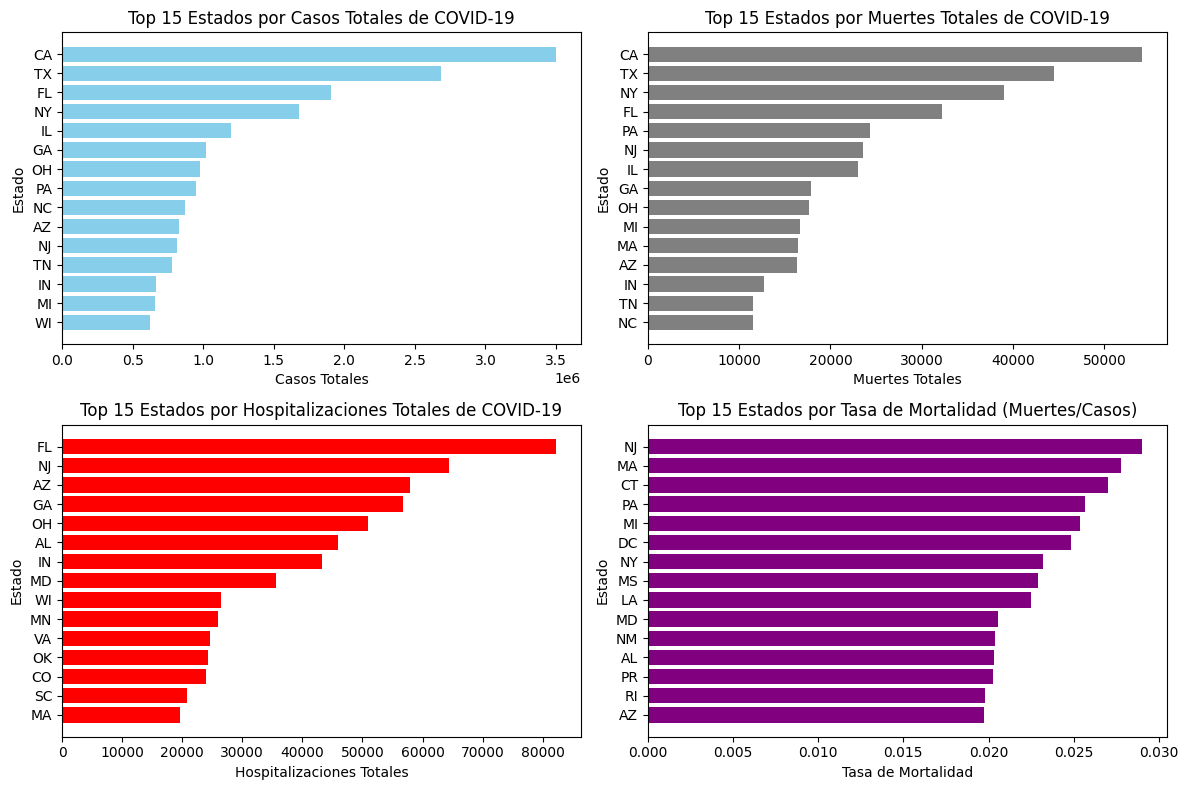

In [17]:
# Añadimos la columna de mortalidad al resumen por estados
state_summary['mortality_rate'] = state_summary['death'] / state_summary['positive']

# Calcular los 15 principales estados por casos totales, muertes y hospitalizaciones
top_cases = state_summary.nlargest(15, 'positive').sort_values(by='positive', ascending=True)
top_deaths = state_summary.nlargest(15, 'death').sort_values(by='death', ascending=True)
top_hospitalizations = state_summary.nlargest(15, 'hospitalizedIncrease').sort_values(by='hospitalizedIncrease', ascending=True)

# Calcular la tasa de mortalidad (muertes/casos) para los principales estados por mortalidad
top_mortality = state_summary.nlargest(15, 'mortality_rate').sort_values(by= 'mortality_rate', ascending=True)


# Configurar una figura con subgráficas 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Graficar los 10 principales estados por casos totales
axs[0, 0].barh(top_cases['state'], top_cases['positive'], color='skyblue')
axs[0, 0].set_title('Top 15 Estados por Casos Totales de COVID-19')
axs[0, 0].set_xlabel('Casos Totales')
axs[0, 0].set_ylabel('Estado')

# Graficar los 10 principales estados por muertes totales
axs[0, 1].barh(top_deaths['state'], top_deaths['death'], color='grey')
axs[0, 1].set_title('Top 15 Estados por Muertes Totales de COVID-19')
axs[0, 1].set_xlabel('Muertes Totales')
axs[0, 1].set_ylabel('Estado')

# Graficar los 10 principales estados por hospitalizaciones
axs[1, 0].barh(top_hospitalizations['state'], top_hospitalizations['hospitalizedIncrease'], color='red')
axs[1, 0].set_title('Top 15 Estados por Hospitalizaciones Totales de COVID-19')
axs[1, 0].set_xlabel('Hospitalizaciones Totales')
axs[1, 0].set_ylabel('Estado')

# Graficar la tasa de mortalidad
axs[1, 1].barh(top_mortality['state'], top_mortality['mortality_rate'], color='purple')
axs[1, 1].set_title('Top 15 Estados por Tasa de Mortalidad (Muertes/Casos)')
axs[1, 1].set_xlabel('Tasa de Mortalidad')
axs[1, 1].set_ylabel('Estado')

plt.tight_layout()
plt.show()



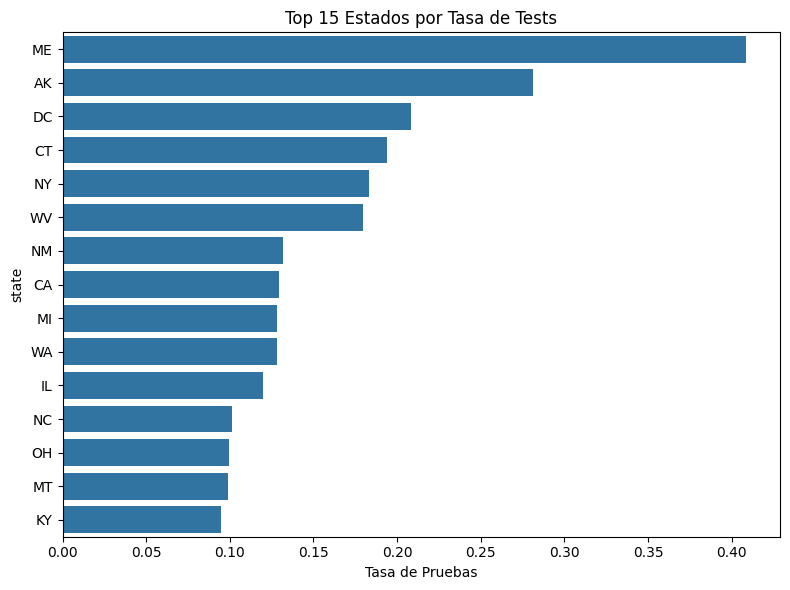

In [19]:
# Calcular y visualizar tasas de testing
state_summary['testing_rate'] = state_summary['totalTestResultsIncrease'] / state_summary['total']
plt.figure(figsize=(8, 6))
sns.barplot(x='testing_rate', y='state', data=state_summary.sort_values('testing_rate', ascending=False).head(15))
plt.title('Top 15 Estados por Tasa de Tests')
plt.xlabel('Tasa de Pruebas')
plt.tight_layout()
plt.show()

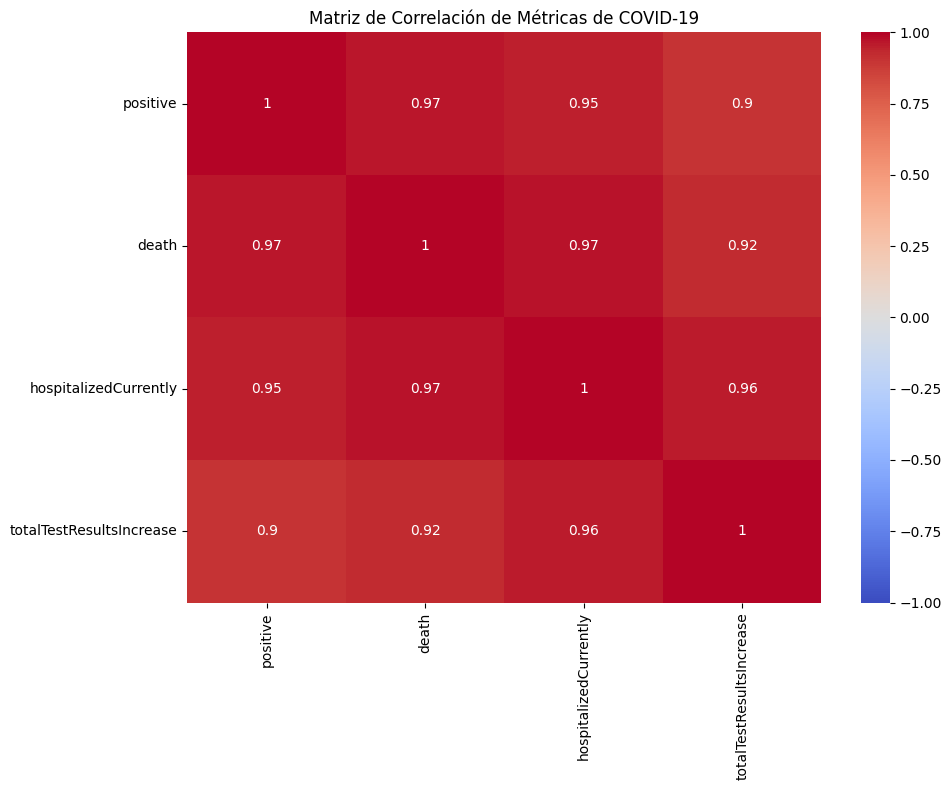

In [20]:
# Análisis de correlación en el resumen por estado
correlation_metrics = ['positive', 'death', 'hospitalizedCurrently', 'totalTestResultsIncrease']
correlation_matrix = state_summary[correlation_metrics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación de Métricas de COVID-19')
plt.tight_layout()
plt.show()

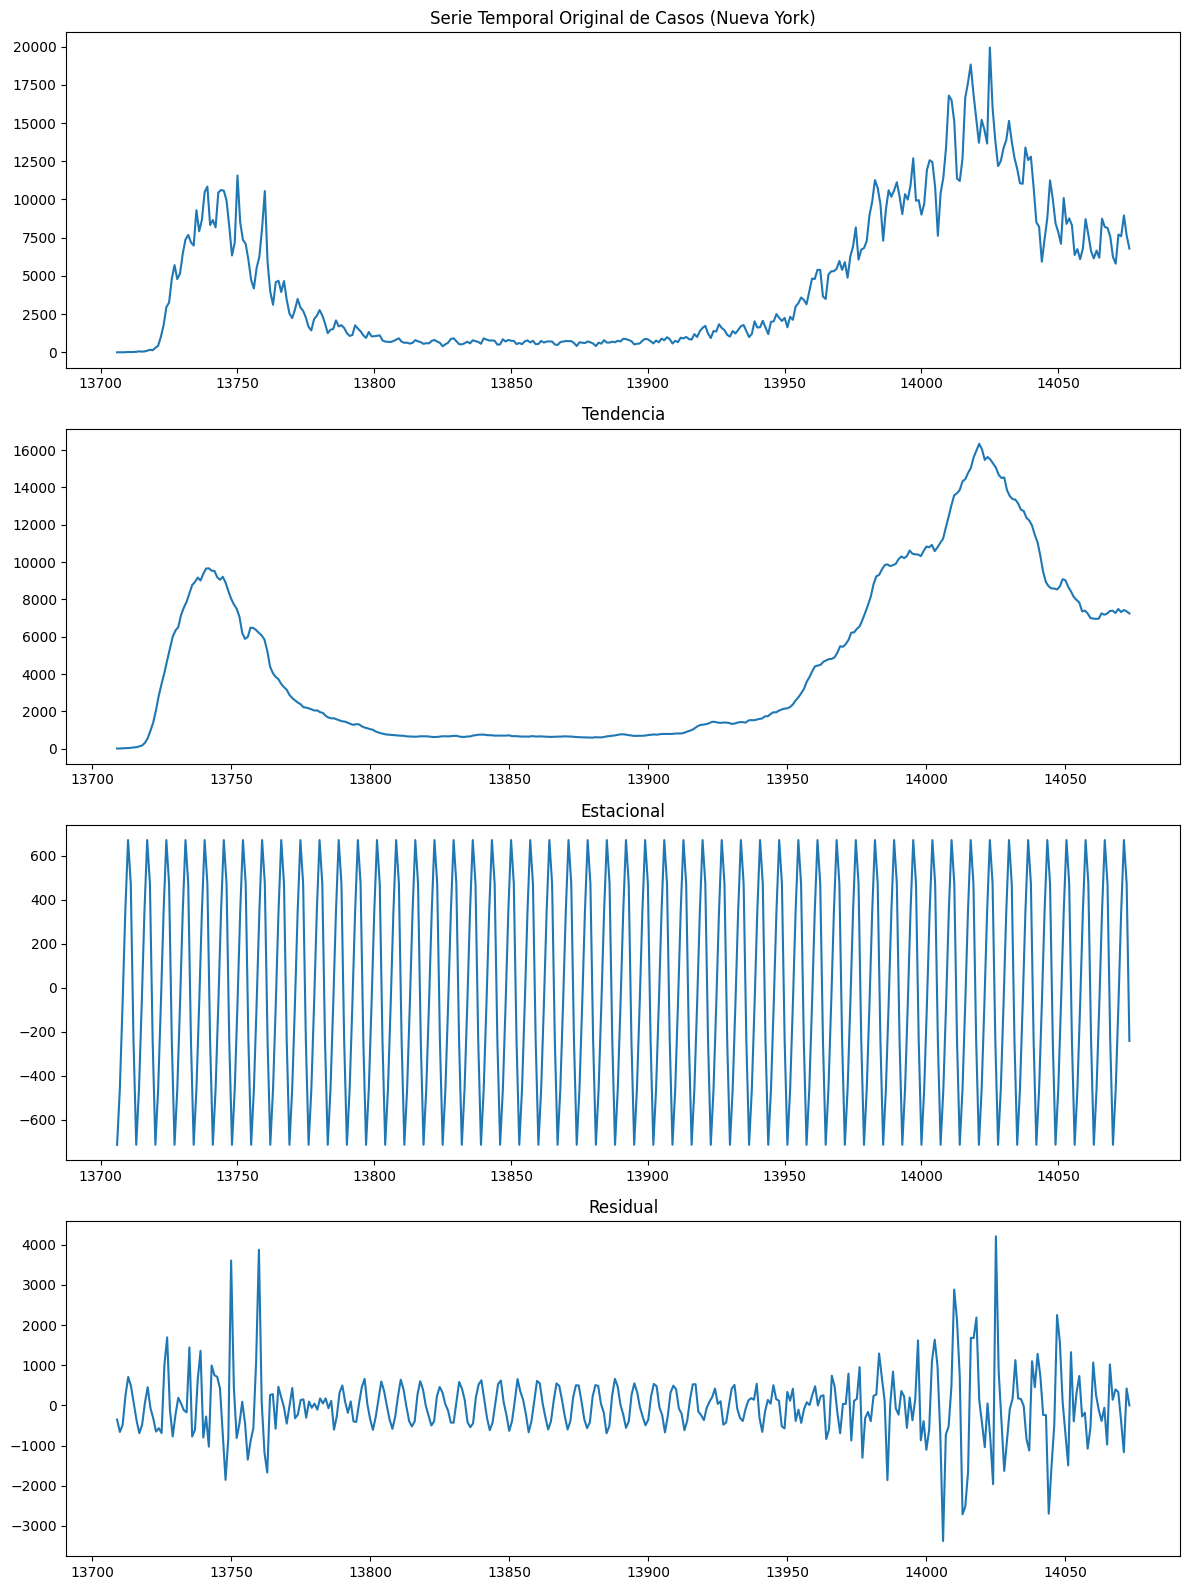

In [18]:
# Calcular promedios móviles para métricas clave
state_df['rolling_avg_cases'] = state_df.groupby('state')['positiveIncrease'].rolling(window=14).mean().reset_index(0, drop=True)
state_df['rolling_avg_deaths'] = state_df.groupby('state')['deathIncrease'].rolling(window=14).mean().reset_index(0, drop=True)

# Calcular tasa de positividad de pruebas
state_df['positivity_rate'] = state_df['positiveIncrease'] / state_df['totalTestResultsIncrease']


#  Realizar descomposición de series temporales
def decompose_time_series(state_data):
    result = seasonal_decompose(state_data['positiveIncrease'], model='additive', period=7)
    return pd.DataFrame({
        'tendencia': result.trend,
        'estacional': result.seasonal,
        'residual': result.resid
    })

# Ejemplo para un estado (por ejemplo, Nueva York)
ny_decomposition = decompose_time_series(state_df[state_df['state'] == 'NY'])


# Visualizar descomposición de series temporales para Nueva York
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
ax1.plot(ny_decomposition.index, state_df[state_df['state'] == 'NY']['positiveIncrease'])
ax1.set_title('Serie Temporal Original de Casos (Nueva York)')
ax2.plot(ny_decomposition.index, ny_decomposition['tendencia'])
ax2.set_title('Tendencia')
ax3.plot(ny_decomposition.index, ny_decomposition['estacional'])
ax3.set_title('Estacional')
ax4.plot(ny_decomposition.index, ny_decomposition['residual'])
ax4.set_title('Residual')
plt.tight_layout()
plt.show()



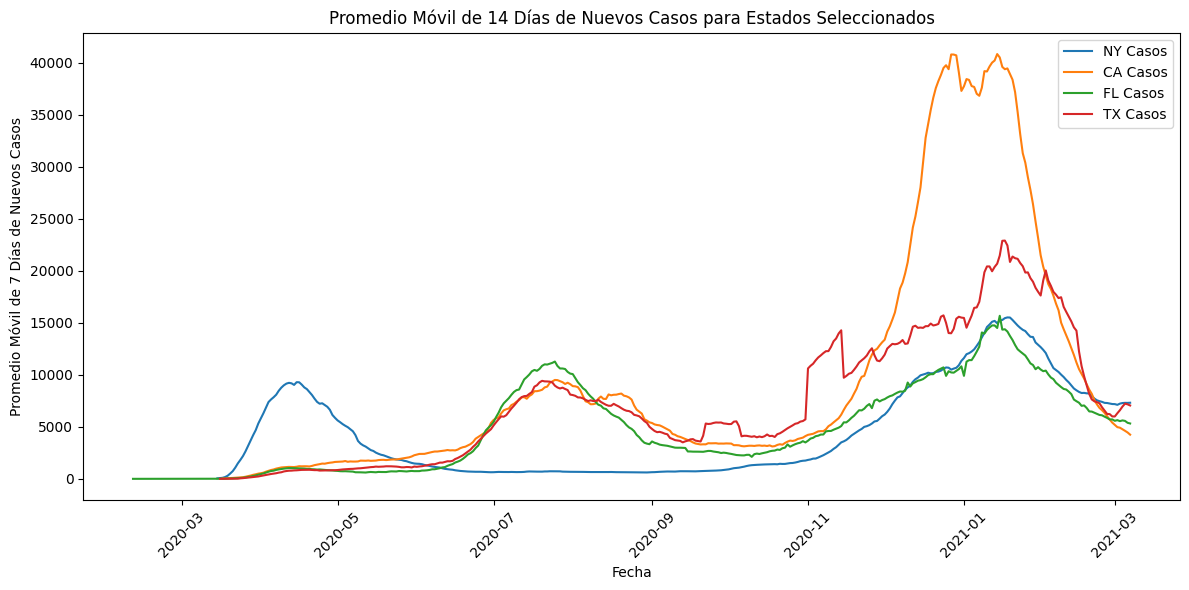

In [20]:
#  Visualizar información adicional

# Graficar promedios móviles
plt.figure(figsize=(12, 6))
for state in ['NY', 'CA', 'FL', 'TX']:  # Ejemplo de estados
    state_data = state_df[state_df['state'] == state]
    plt.plot(state_data['date'], state_data['rolling_avg_cases'], label=f'{state} Casos')
plt.title('Promedio Móvil de 14 Días de Nuevos Casos para Estados Seleccionados')
plt.xlabel('Fecha')
plt.ylabel('Promedio Móvil de 7 Días de Nuevos Casos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


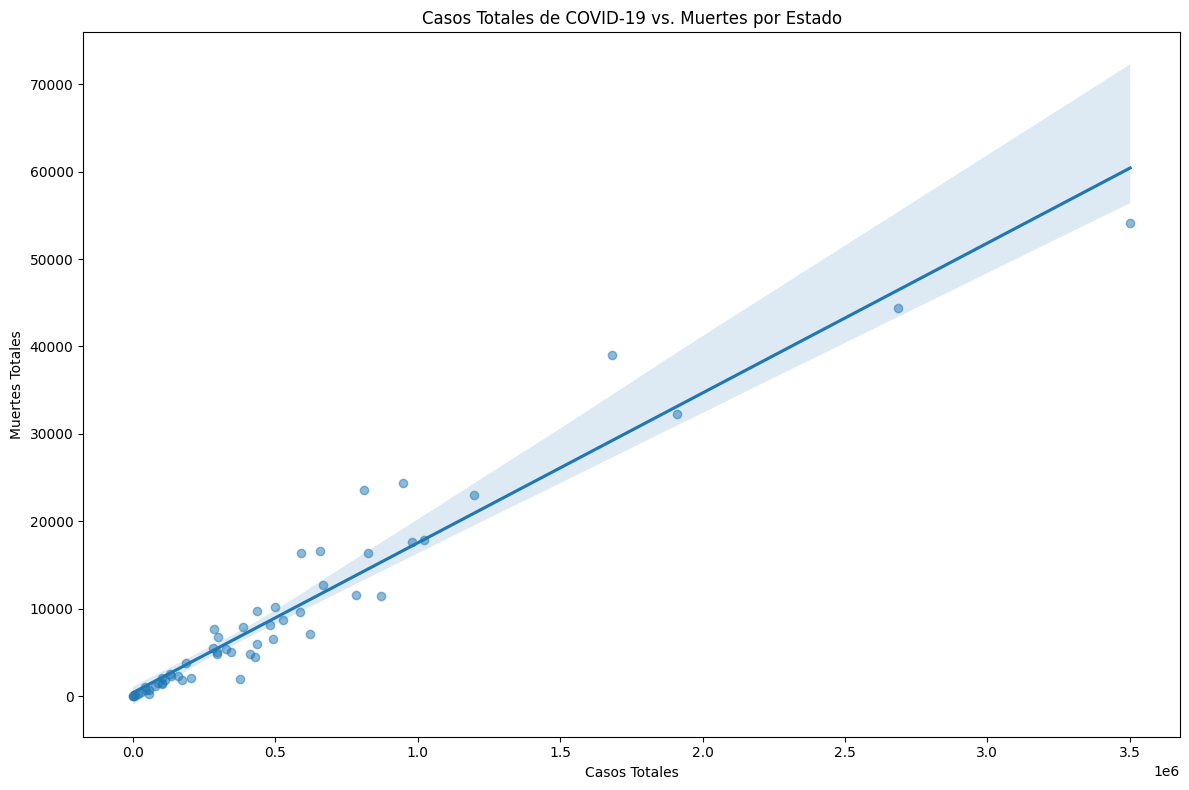

In [19]:
# Gráfico de dispersión de casos totales vs. muertes totales con línea de regresión
plt.figure(figsize=(12, 8))
sns.regplot(x='positive', y='death', data=state_summary, scatter_kws={'alpha':0.5})
plt.title('Casos Totales de COVID-19 vs. Muertes por Estado')
plt.xlabel('Casos Totales')
plt.ylabel('Muertes Totales')
plt.tight_layout()
plt.show()


# Análisis del Impacto del COVID-19 en EEUU durante el Periodo Ene 2020 - Mar 2021

## Resumen

Este análisis examina el impacto del COVID-19 en el primer año en Estados Unidos, centrándose en datos a nivel estatal sobre casos, muertes, hospitalizaciones y métricas relacionadas.

## Hallazgos Clave

1. **Distribución de Casos**: California, Texas, Florida y Nueva York aparecen constantemente como los estados con el mayor número total de casos. Esto se alinea con sus grandes poblaciones, pero también sugiere que estos estados enfrentaron desafíos significativos en el control de la propagación del virus.

2. **Número de Muertes**: Nueva York, California, Texas y Florida reportaron el mayor número de muertes. Notablemente, el número de muertes de Nueva York es desproporcionadamente alto en comparación con su número de casos, lo que indica una tasa de mortalidad potencialmente más alta o desafíos en la respuesta temprana a la pandemia. Ocurre lo mismo en estados fronterizos con NY, por ejemplo New Jersey.

3. **Hospitalizaciones**: Florida, Nueva Jersey y Arizona reportaron el mayor número de hospitalizaciones. Esto sugiere que estos estados pueden haber enfrentado una tensión particular en sus sistemas de atención médica.

4. **Tasa de Mortalidad**: La tasa de mortalidad (muertes/casos) varía significativamente entre los estados. Nueva Jersey, Massachusetts,
Nueva York y Pensilvania muestran tasas de mortalidad más altas, lo que podría deberse a factores como la densidad de población, la demografía de edad, la capacidad del sistema de atención médica o las estrategias de respuesta temprana a la pandemia.

5. **Tasas de Pruebas**: El análisis incluye las tasas de pruebas, lo que es crucial para comprender la verdadera propagación del virus. Los estados con tasas de pruebas más altas pueden inicialmente mostrar un mayor número de casos, pero podrían estar mejor posicionados para controlar la propagación a través de la detección temprana y el aislamiento.

6. **Tendencias de Series Temporales**: Las medias móviles de los nuevos casos muestran distintas ondas de infección, con picos y valles que varían según el estado. Esto sugiere diferentes líneas de tiempo de brote y esfuerzos de contención en los estados.

7. **Retraso Entre Casos y Muertes**: El análisis de la correlación de retraso entre casos y muertes proporciona información sobre la progresión típica de la enfermedad y la efectividad del tratamiento a lo largo del tiempo.

## Reseñas por Estados

1. **Nueva York**: Enfrentó un brote temprano severo con una alta tasa de mortalidad. La respuesta del estado evolucionó con el tiempo, lo que potencialmente mejoró los resultados en olas posteriores.

2. **California**: Alto número total de casos pero una tasa de mortalidad más baja en comparación con Nueva York, lo que sugiere una respuesta de atención médica potencialmente más efectiva o diferencias en la vulnerabilidad de la población.

3. **Florida**: Altos números de casos y hospitalizaciones, pero una tasa de mortalidad más baja que algunos otros estados fuertemente afectados. Esto podría indicar protocolos de tratamiento efectivos o diferencias en la población afectada.

4. **Texas**: Patrón similar a Florida con altos números de casos pero una tasa de mortalidad más baja que los estados de brote temprano.

5. **Nueva Jersey**: Alta tasa de mortalidad y hospitalizaciones significativas en relación con su población, lo que indica un impacto severo y una posible tensión en el sistema de atención médica.


## Conclusiones

El primer año de la pandemia de COVID-19 en EE. UU. reveló variaciones significativas en el impacto y la respuesta entre los estados. Si bien el tamaño de la población jugó un papel en el número total de casos, factores como el momento de la respuesta temprana, la capacidad del sistema de atención médica y la efectividad de las medidas de salud pública seguramente influyeron significativamente en los resultados.



## Documentación de la API y el significado de las columnas en  https://covidtracking.com/data/api
